In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

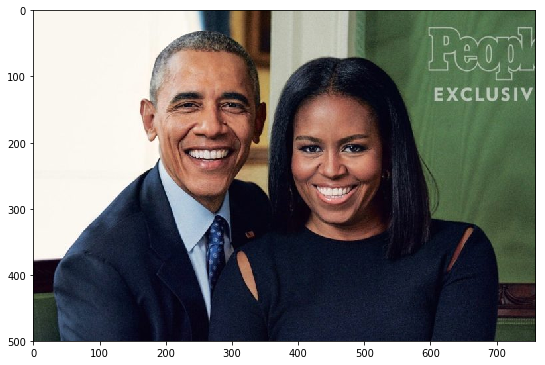

In [3]:
import cv2
# load in color image for face detection
image = cv2.imread('/content/drive/My Drive/P1_Facial_Keypoints-master/images/obamas.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


(2, 4)


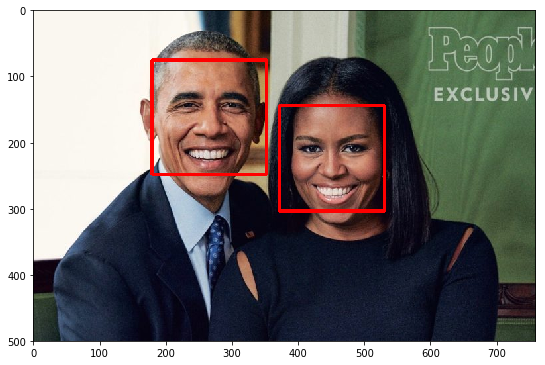

In [4]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/P1_Facial_Keypoints-master/detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)
print(faces.shape)
# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [5]:

import torch
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        ## TODO: Define all the layers of this CNN, the only requirements are:
        ## 1. This network takes in a square (same width and height), grayscale image as input
        ## 2. It ends with a linear layer that represents the keypoints
        ## it's suggested that you make this last layer output 136 values, 2 for each of the 68 keypoint (x, y) pairs
        
        # As an example, you've been given a convolutional layer, which you may (but don't have to) change:
        # 1 input image channel (grayscale), 32 output channels/feature maps, 5x5 square convolution kernel
        
        # convolutional layer (sees 224x224x1 image tensor)
        self.conv1 = nn.Conv2d(1, 3, 5, padding=2)
        # convolutional layer (sees 112x112x3 tensor)
        self.conv2 = nn.Conv2d(3, 9, 5, padding=2)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (9 * 56 * 56 -> 500)
        self.fc1 = nn.Linear(9 * 56 * 56, 300)
        # linear layer (300-> 136)
        self.fc2 = nn.Linear(300, 136)
        # dropout layer (p=0.20)
        self.dropout = nn.Dropout(0.20)
        ## Note that among the layers to add, consider including:
        # maxpooling layers, multiple conv layers, fully-connected layers, and other layers (such as dropout or batch normalization) to avoid overfitting
        

        
    def forward(self, x):
        ## TODO: Define the feedforward behavior of this model
        ## x is the input image and, as an example, here you may choose to include a pool/conv step:
        ## x = self.pool(F.relu(self.conv1(x)))
        
         # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # flatten image input
        x = x.view(-1, 9 * 56 * 56)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        

        # a modified x, having gone through all the layers of your model, should be returned
        return x


## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you





net = Net()
net.cuda()

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
net.load_state_dict(torch.load('/content/drive/My Drive/P1_Facial_Keypoints-master/saved_modelskeypoints_model_1.pt'))

#print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(3, 9, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28224, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=136, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [6]:
net.eval()

Net(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(3, 9, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28224, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=136, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you'll wrap that Tensor in a Variable() and can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




**Show_all_keypoint()** fuction from notebook 2

In [0]:
def show_all_keypoints(image, predicted_key_pts):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], 10, marker='.', c='m')

(224, 224, 1)


<Figure size 432x288 with 0 Axes>

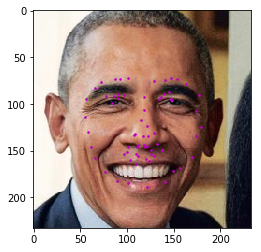

(224, 224, 1)


<Figure size 432x288 with 0 Axes>

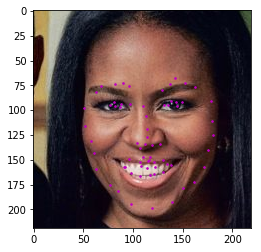

In [90]:
image_copy = np.copy(image)

# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    
    # Select the region of interest that is the face in the image 
    roi = image_copy[y-30:y+h+30, x-30:x+w+30]
    
    
    roi_copy = np.copy(roi) # will be used as background to display final ke
    
    #plt.imshow(roi)
    
    ## TODO: Convert the face region from RGB to grayscale
    gray = cv2.cvtColor(roi,cv2.COLOR_RGB2GRAY)
    #print(gray.shape)
    
    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    gray = gray/255
    #plt.imshow(gray)

    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    gray = cv2.resize(gray, (224,224))
   
    gray = gray.reshape(gray.shape[0], gray.shape[1], 1)
    gray_copy = np.copy(gray)

    print(gray.shape)
    
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)

    gray = gray.transpose((2, 0, 1))
    gray = torch.from_numpy(gray)
    gray = gray.type(torch.FloatTensor).cuda()
    gray= gray.view(1,1,224,224)
    #print(gray.shape)
    
    ## TODO: Make facial keypoint predictions using your loaded, trained network 
    result = net(gray)
    result = result.view(68, 2)

    result = result.detach().cpu().numpy()
    # undo normalization of keypoints  
    result = result*50.0+100
    
    #print(result)

    
    ## TODO: Display each detected face and the corresponding keypoints   
    plt.figure() 
     
    # Using helper function for display as defined previously.  
    show_all_keypoints(roi_copy, result)
    plt.show()     
    